# EP1
## Cálculo do Conjunto de Mandelbrotem Paralelo com Pthreads e OpenMP

Nesse EP temos apenas quatro membros pois um trancou a materia:

| Nome | NUSP |
|------|------|
| Daniel Hotta | 9922700 |
| Matheus Laurentys | 9793714 |
| Pedro Gigeck | 10737136 |
| Rafael Gonçalves | 9009600 |


## Configuração do Ambiente

O ambiente será herdado do miniEP3

In [13]:
] up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `~/github/mac-0219/EP1/src/Project.toml`
 [no changes]
  Updating `~/github/mac-0219/EP1/src/Manifest.toml`
  [aaaa29a8] ↑ Clustering v0.13.4 ⇒ v0.14.0
  [b4f34e82] ↓ Distances v0.9.0 ⇒ v0.8.2
  [b8a86587] ↓ NearestNeighbors v0.4.5 ⇒ v0.4.4


In [14]:
] st

    Status `~/github/mac-0219/EP1/src/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.1
  [31c24e10] Distributions v0.23.2
  [7073ff75] IJulia v1.21.2
  [8314cec4] PGFPlotsX v1.2.6
  [91a5bcdd] Plots v1.3.2
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6



## Medição do tempo

Para medir o tempo de execução geral, usamos o script `run_measurements.sh`, com o comando `perf`, que foi passado no enunciado. Todas as medições foram feitas com 13 repetições.

Para medir o tempo de execução descontando as operações de I/O e alocação de memória, nós calculamos os tempos com algumas repetições da versão sequencial e usamos a opção do perf que separa o tempo de execução por cada comando específico do código, assim conseguimos obter o tempo gasto por cada função.

## Sobre as Implementações

A implementação sequencial `mandelbrot_seq.c` foi mantida intacta.

A implementação com OpenMP `mandelbrot_omp.c` foi bastante simples, o cálculo é igual ao sequêncial, porém o for externo foi trocado por um for paralelo do omp, compartilhando a váriavel `i_y`. Dessa forma, cada thread cuida de um intervalo de valores do `i_y`.

A implementação com Pthreads `mandelbrot_pth.c` seguiu a mesma lógica da com OMP, paralelizando o for externo. Cada thread recebe um `i_y` inicial e um `i_y` final e calcula as linhas esquivalentes a esse intervalo. A diferença é que as estruturas das threads e a divisão dos intervalos foram feitos explicitamente.

## Executando

O primeiro passo é compilar todo o codigo deste EP

In [15]:
; make

make: Nothing to be done for 'all'.


In [16]:
Podemos rodar qualquer uma das implementações para observar as imagens, por exemplo

LoadError: syntax: extra token "rodar" after end of expression

In [17]:
; ./mandelbrot_seq -2.5 1.5 -2.0 2.0 11500

4.215612
2.477938
===


Por fim, rodamos os scripts com os experimentos. Esse script leva algumas horas e ira subtituir a pasta (que se encontra pronta) results. Nao deve ser rodada novamente.

In [18]:
#; ./run_measurements.sh

In [19]:
using Pkg
Pkg.add("DataFrames")

using DataFrames

# Build global DataFrame with the I/O and MemAlloc Times
disc = DataFrame()
logs = ["full" "elephant" "seahorse" "triple_spiral"]
for l in logs
    lT = string(l, "T")
    out = Pipe()
    cmd = pipeline(`cat times/$lT.log`, out)
    run(cmd)
    close(out.in)
    s = read(out, String)
    s = split(s, '\n')
    pop!(s)
    v = []
    aux = 0
    for j in s
        if j == "==="
            push!(v, aux)
            aux = 0
        else
            aux += parse(Float64, j)
        end
    end
    disc[!, "$l"] = v
end

 Resolving package versions...
  Updating `~/github/mac-0219/EP1/src/Project.toml`
 [no changes]
  Updating `~/github/mac-0219/EP1/src/Manifest.toml`
  [aaaa29a8] ↓ Clustering v0.14.0 ⇒ v0.13.4
  [b4f34e82] ↑ Distances v0.8.2 ⇒ v0.9.0
  [b8a86587] ↑ NearestNeighbors v0.4.4 ⇒ v0.4.5


 Resolving package versions...
  Updating `~/github/mac-0219/EP1/src/Project.toml`
 [no changes]
  Updating `~/github/mac-0219/EP1/src/Manifest.toml`
 [no changes]
SubString{String}["0.020459", "0.02928", "0.004281570", "0.004213217", "0.014607239", "0.056722729", "0.220465196", "0.903395480", "3.266285123", "13.900983681"]
1
2
3
4
5
6
7
8
9
10
SubString{String}["0.03143", "0.0414", "0.005155403", "0.018913305", "0.072608208", "0.286784649", "1.141679701", "4.317338614", "17.014542937", "69.414639326"]
1
2
3
4
5
6
7
8
9
10
SubString{String}["0.0878", "0.0484", "0.021600980", "0.019791952", "0.077278987", "0.303663109", "1.203257476", "4.744640908", "17.909734766", "74.019418801"]
1
2
3
4
5
6
7
8
9
10
SubString{String}["0.0703", "0.0952", "0.006002120", "0.022381345", "0.096779658", "0.342454732", "1.358415895", "5.083272680", "20.689712770", "83.626534254"]
1
2
3
4
5
6
7
8
9
10


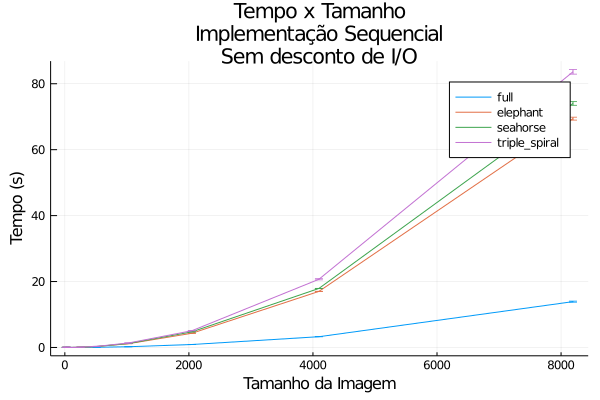

In [32]:
# Plot sequencial graphs

import Pkg
Pkg.add("Plots")
using DataFrames, Plots

# DataFrame to concat all data to write in csv
df_csv = DataFrame()
df_csv.sz = [2 ^ x for x in 4:13]

# Get the time values from the log files and saves in a string
function get_log_string(log)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_seq/$log.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get the percent values of the error from the log files and saves in a string
function get_log_deviation(log)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_seq/$log.log`,
          pipeline(`awk '{print $(NF - 1)}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Transform the strings of times and error into float arrays
function get_values(values, percent, discount)
    values = split(values, '\n')
    percent = split(percent, '\n')
    pop!(values)
    pop!(percent)
    times = []
    error = []
    println(values)
    for i in 1:length(values)
        println(i)
        t = parse(Float64, replace(values[i], ","=>"."))
        if discount != nothing
            t -= discount[i]
        end
        push!(times, t)
        e = parse(Float64, replace(replace(percent[i], ","=>"."), "%"=>""))
        push!(error, (t*e)/100)
    end
    return times, error
end

# Create a dataframe with values from the 4 log files, discount tells if we discount I/O operations
function get_data_frame(discount)
    df = DataFrame()
    df.sz = [2 ^ x for x in 4:13]
    for l in logs
        s = get_log_string(l)
        d = get_log_deviation(l)
        if discount
            dc = disc["$l"]
        else
            dc = nothing
        end
        times, dv = get_values(s, d, dc)
        df[!, "$l"] = times
        df[!, "dv$l"] = dv
        df_csv[!, "seq_$l.times"] = times
        df_csv[!, "seq_$l.error"] = dv
    end
    return df
end

function plot_data_frame(df, d)
    xs = df.sz
    ys = [df.full df.elephant df.seahorse df.triple_spiral]
    deviation = [df.dvfull df.dvelephant df.dvseahorse df.dvtriple_spiral]
    plot(xs, ys, label = logs, yerror = deviation, 
         xlabel = "Tamanho da Imagem", ylabel = "Tempo (s)", title = "Tempo x Tamanho\nImplementação Sequencial\n$d")
end

df = get_data_frame(false)
plot_data_frame(df, "Sem desconto de I/O")


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = get_data_frame(::Bool) at In[20]:63
└ @ Main ./In[20]:63


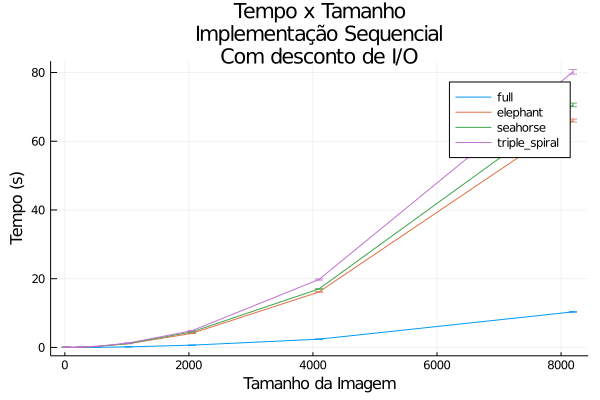

In [21]:
df = get_data_frame(true)
plot_data_frame(df, "Com desconto de I/O")

 Resolving package versions...
  Updating `~/github/mac-0219/EP1/src/Project.toml`
 [no changes]
  Updating `~/github/mac-0219/EP1/src/Manifest.toml`
 [no changes]


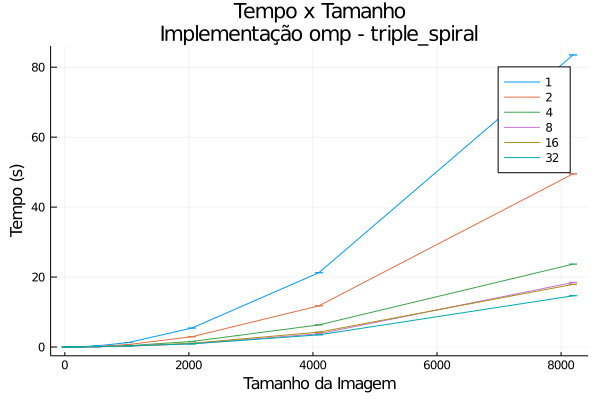

omp
1
SubString{String}["0.000951332", "0.002051519", "0.006138023", "0.022702027", "0.091565463", "0.340206038", "1.349241020", "5.649936466", "22.189141474", "86.928329475"]
1
2
3
4
5
6
7
8
9
10
omp
2
SubString{String}["0.000956679", "0.001529898", "0.003944858", "0.013124421", "0.050199468", "0.193937292", "0.771157549", "3.164456045", "12.713662267", "52.930476134"]
1
2
3
4
5
6
7
8
9
10
omp
4
SubString{String}["0.001117267", "0.012947187", "0.002890674", "0.008469277", "0.032924302", "0.127398861", "0.451895188", "1.813709926", "7.251820547", "27.127769020"]
1
2
3
4
5
6
7
8
9
10
omp
8
SubString{String}["0.003793275", "0.002943475", "0.019465150", "0.008592329", "0.020491158", "0.077226265", "0.331480444", "1.155172117", "4.714751098", "21.885976749"]
1
2
3
4
5
6
7
8
9
10
omp
16
SubString{String}["0.001956122", "0.002288241", "0.003600250", "0.007693161", "0.036316411", "0.121723297", "0.335774550", "1.302882724", "5.183124946", "21.341571367"]
1
2
3
4
5
6
7
8
9
10
omp
32
SubString{

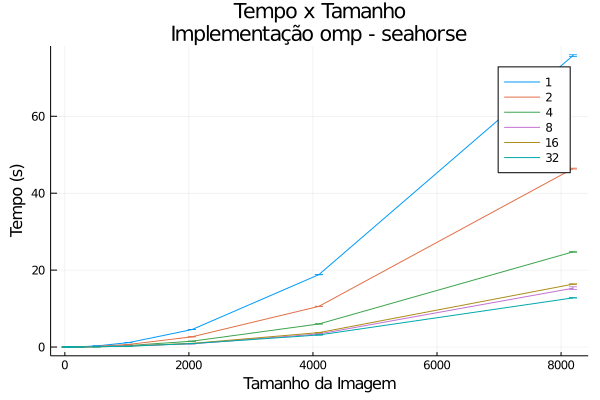

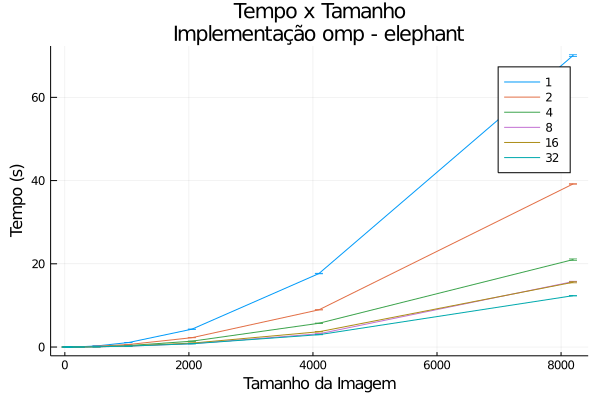


3
4
5
6
7
8
9
10
omp
16
SubString{String}["0.001691360", "0.001932403", "0.003163120", "0.007587370", "0.021698919", "0.081754738", "0.299156414", "1.170414708", "4.633007987", "19.807780873"]
1
2
3
4
5
6
7
8
9
10
omp
32
SubString{String}["0.002493167", "0.002323986", "0.012214412", "0.006699814", "0.019174792", "0.085344884", "0.259710703", "1.111237357", "4.022659747", "16.239105698"]
1
2
3
4
5
6
7
8
9
10
omp
1
SubString{String}["0.000867908", "0.001834466", "0.005374292", "0.019861955", "0.076619366", "0.284170681", "1.133078083", "4.506593219", "18.537804448", "73.430150073"]
1
2
3
4
5
6
7
8
9
10
omp
2
SubString{String}["0.000959887", "0.001435974", "0.003382438", "0.010756414", "0.039890865", "0.190411842", "0.665521208", "2.462094106", "9.822766844", "42.576345821"]
1
2
3
4
5
6
7
8
9
10
omp
4
SubString{String}["0.001032323", "0.001662108", "0.002630641", "0.007420268", "0.029411278", "0.106480397", "0.412537686", "1.621729547", "6.590844870", "24.395313935"]
1
2
3
4
5
6
7
8
9
10

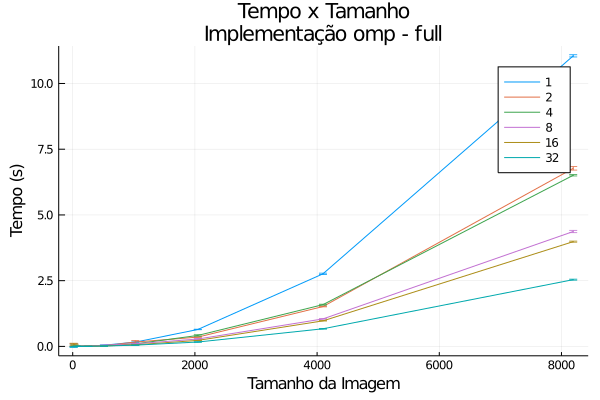

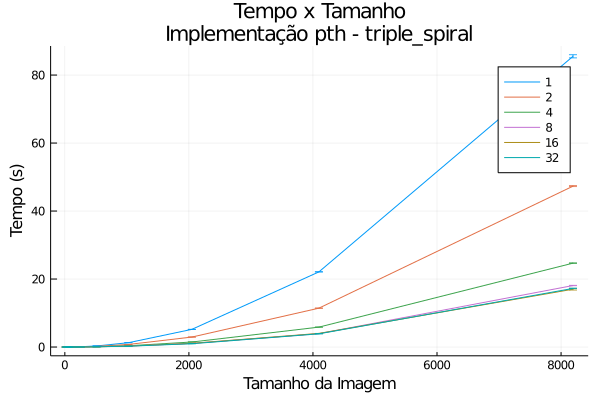

SubString{String}["0.002488610", "0.000817346", "0.001499400", "0.004181004", "0.014984620", "0.060204344", "0.217996038", "0.878618162", "3.616463234", "14.596307698"]
1
2
3
4
5
6
7
8
9
10
omp
2
SubString{String}["0.084360991", "0.000971149", "0.001665618", "0.003273762", "0.010413303", "0.038410378", "0.222018896", "0.588344613", "2.371904475", "10.317903700"]
1
2
3
4
5
6
7
8
9
10
omp
4
SubString{String}["0.054552760", "0.001084642", "0.001375032", "0.003421465", "0.010873879", "0.039003398", "0.152306662", "0.651619126", "2.444416430", "10.054721482"]
1
2
3
4
5
6
7
8
9
10
omp
8
SubString{String}["0.073767750", "0.004504784", "0.006038513", "0.004751125", "0.011250913", "0.057802266", "0.155195265", "0.515478418", "1.901648478", "7.915557808"]
1
2
3
4
5
6
7
8
9
10
omp
16
SubString{String}["0.092715014", "0.064471902", "0.002371270", "0.003748803", "0.008982398", "0.030977651", "0.116372139", "0.462873197", "1.827744162", "7.530268994"]
1
2
3
4
5
6
7
8
9
10
omp
32
SubString{String}["0

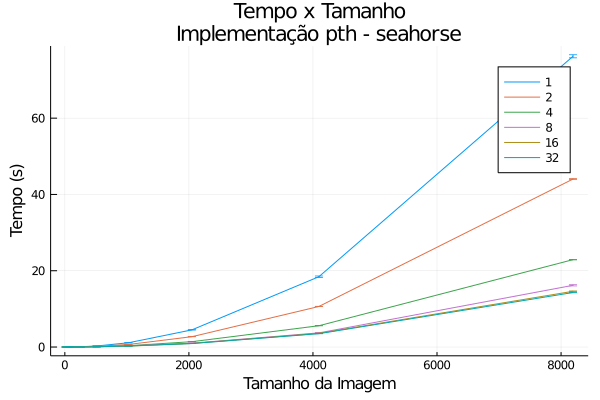

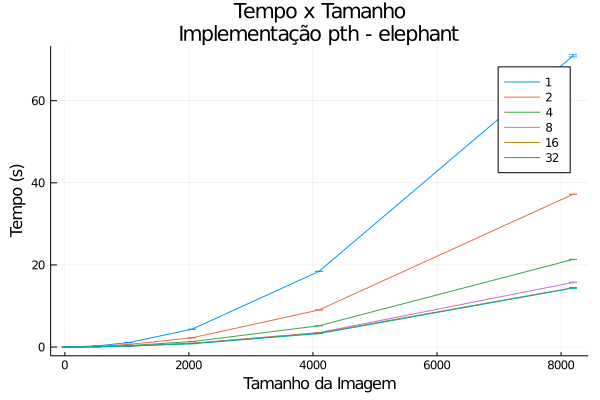


1
SubString{String}["0.000841038", "0.001745069", "0.005398663", "0.020679796", "0.076032015", "0.298789350", "1.170083513", "4.719016998", "19.322547474", "79.670760301"]
1
2
3
4
5
6
7
8
9
10
pth
2
SubString{String}["0.007175736", "0.001294272", "0.003484390", "0.012308900", "0.050562749", "0.194670490", "0.729318163", "2.930989943", "11.518735267", "47.496411689"]
1
2
3
4
5
6
7
8
9
10
pth
4
SubString{String}["0.000707651", "0.001080874", "0.002438911", "0.007516979", "0.027456238", "0.114191445", "0.416406075", "1.621775363", "6.468784896", "26.362956358"]
1
2
3
4
5
6
7
8
9
10
pth
8
SubString{String}["0.000821698", "0.001122743", "0.002101493", "0.005559046", "0.018868763", "0.072493889", "0.376055991", "1.230886579", "4.592348386", "19.634302749"]
1
2
3
4
5
6
7
8
9
10
pth
16
SubString{String}["0.001075379", "0.001437006", "0.002916258", "0.005747083", "0.021398425", "0.093822139", "0.289563653", "1.163082178", "4.483899662", "18.067189567"]
1
2
3
4
5
6
7
8
9
10
pth
32
SubString{Str

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = get_data_frame(::String, ::String) at In[38]:42
└ @ Main ./In[38]:42


BoundsError: BoundsError: attempt to access 10-element Array{Any,1} at index [11]

In [38]:
# Plot the paralell graphs

import Pkg
Pkg.add("Plots")
using DataFrames, Plots

# Get the time values from the log files and saves in a string
function get_log_string(log, implementation, th)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_$implementation/$log$th.log`,
          pipeline(`awk '{print $1}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get the percent values of the error from the log files and saves in a string
function get_log_deviation(log, implementation, th)
    out = Pipe()
    cmd = pipeline(`grep '.seconds time elapsed.' results/mandelbrot_$implementation/$log$th.log`,
          pipeline(`awk '{print $(NF - 1)}'`; stdout=out))
    
    run(cmd)
    close(out.in)
    s = read(out, String)
    return s
end

# Get a dataFrame (time x image_size) with data  
function get_data_frame(implementation, image)
    df = DataFrame()
    df.sz = [2 ^ x for x in 4:13]
    th = [2 ^ x for x in 0:5]
    for t in th
        println(implementation)
        println(t)
        s = get_log_string(image, implementation, string(t))
        d = get_log_deviation(image, implementation, string(t))
        
        dc = disc["$image"]
        
        times, dv = get_values(s, d, dc)
        df[!, "t$t"] = times
        df[!, "dv$t"] = dv
        df_csv[!, "$implementation.$image$t.times"] = times
        df_csv[!, "$implementation.$image$t.error"] = dv
    end
    return df
end

# Função para plotar o DataFrame
function plot_data_frame(df, i, j)
    xs = df.sz
    ys = [df.t1 df.t2 df.t4 df.t8 df.t16 df.t32]
    deviation = [df.dv1 df.dv2 df.dv4 df.dv8 df.dv16 df.dv32]
    labels = ["1" "2" "4" "8" "16" "32"]
    display(plot(xs, ys, label = labels, yerror = deviation, 
         xlabel = "Tamanho da Imagem", ylabel = "Tempo (s)", title = "Tempo x Tamanho\nImplementação $i - $j"))
end

implementations = ["omp" "pth"]
file = ["triple_spiral","seahorse","elephant","full"]
for i in implementations
    for j in file
        df = get_data_frame(i, j)
        plot_data_frame(df, i, j)
    end
end

In [23]:
using CSV

CSV.write("data", df_csv)

"data"

### Análise da implementação sequencial

Com a implementação sequencial, vemos uma clara diferença entre as regiões do Conjunto de Mandelbrot. 

A geração da imagem completa (full) consome muito menos tempo que as regiões específicas, uma das causas pode ser o grande intervalo de pontos que cada pixel da imagem abrange, causando uma baixa definição e, com isso, menos iterações de cálculo. As regiões específicas, que cobriam subconjuntos de tamanhos semelhantes consumiram tempos parecidos. 

Outra observação interessante é o comportamento quadrático do consumo de tempo em função do tamanho da lateral imagem, o que faz sentido já que calculamos um dado número de iterações para cada pixel.

### Análise geral das implementações paralelas

No entanto,com as implementeções paralelas conseguimos observar que ,aparentemente, o Conjunto de Mandelbrot paralelizado por
pthreads apresenta um menor tempo para o calculo quando temos 8 threads. 

Além disso, fica evidente uma diferença gritante na maneira em que a evolução do tempo para o calculo das imagens se comporta independente do numero de threads involvido, dado a implementação ser por OpenMP e Pthreads, pois os graficos gerados pela implementação OpenMP apresentam um tempo de execução e taxa de crescimento similar para n threads para as regiões pedidas, enquanto ao nos voltarmos para os graficos gerados pela implementação pthreads temos taxas de crescimento para o tempo de execução por numero de threads mais distintas entre si.


### Análise da implementação com *pthreads*

Aparentemente o tempo de execução aumenta ainda que aumentamos o numero de threads, com exceção de quando rodamos
imagens com 8 threads provavelmente pois , assim como ocorreu no miniep anterior, a quantidade de threads acaba 
ficando muito maior que a quantidade de núcleos de processamento da máquina, assim, não temos um ganho real 
dividindo o trabalho, pois ele terá que ser executado nos mesmos núcleos. Todavia ainda vemos que ainda ganhamos tempo se comparado com a execução sequencial e que assim como na execução sequencial a geração da imagem completa(full) é mais rapida de ser calculada.

### Análise da implementação com OpenMP

Como ja foi dito, a implementação por OpenMP apresentam um tempo de execução e taxa de crescimento similar para n threads para as regiões pedidas, todavia apresentam um tempo consideravelmente mais rapido para determinadas imagens com relação a outras, em especial a imagem denominada " full ".

• 2) Qual o impacto das operações de I/O e alocação de memória no tempo de execução?

#### Especificações do ambiente utilizado para geração das imagens 

 - Host bridge: Intel Corporation Xeon E3-1200 v6/7th Gen Core Processor Host Bridge/DRAM Registers 
 
 - PCI bridge: Intel Corporation Xeon E3-1200 v5/E3-1500 v5/6th Gen Core Processor PCIe Controller (x16) (rev 05)
 
 - VGA compatible controller: Intel Corporation Device 591b (rev 04)
 
 - USB controller: Intel Corporation 100 Series/C230 Series Chipset Family USB 3.0 xHCI Controller (rev 31)
  
 - Signal processing controller: Intel Corporation 100 Series/C230 Series Chipset Family Thermal Subsystem (rev 31)
 
 - Communication controller: Intel Corporation 100 Series/C230 Series Chipset Family MEI Controller #1 (rev 31)
 
 - SATA controller: Intel Corporation HM170/QM170 Chipset SATA Controller [AHCI Mode] (rev 31)
 
 - PCI bridge: Intel Corporation 100 Series/C230 Series Chipset Family PCI Express Root Port #3 (rev f1)
 
 - PCI bridge: Intel Corporation 100 Series/C230 Series Chipset Family PCI Express Root Port #4 (rev f1)
 
 - PCI bridge: Intel Corporation 100 Series/C230 Series Chipset Family PCI Express Root Port #9 (rev f1)
 
 - ISA bridge: Intel Corporation HM175 Chipset LPC/eSPI Controller (rev 31)
 
 - Memory controller: Intel Corporation 100 Series/C230 Series Chipset Family Power Management Controller (rev 31)
 
 - SMBus: Intel Corporation 100 Series/C230 Series Chipset Family SMBus (rev 31)
 
 - VGA compatible controller: NVIDIA Corporation GP106M [GeForce GTX 1060 Mobile] (rev a1)
 
 - Network controller: Intel Corporation Wireless 8265 / 8275 (rev 78)
 
 - Ethernet controller: Realtek Semiconductor Co., Ltd. RTL8111/8168/8411 PCI Express Gigabit Ethernet Controller


In [24]:
using DataFrames

function get_df_time(path) 
    overhead = []
    system = []
    open(path) do f
        for i in eachline(f)
            if occursin(r".+[0-9]+.[0-9]+%", i)
                x = split(i)
                tmp = split(x[1], "%")
                push!(overhead, parse(Float64, tmp[1]))
                push!(system, x[5])
            end
        end
    end
    return df = DataFrame(A = overhead, B = system)
end


df = (get_df_time("results_inter/mandelbrot_seq/full.log"))


function get_time(df)
    time = [0.0, 0.0, 0.0]

    for i in eachrow(df)
        if occursin(r".*mandelbrot.*", i[2,])
            time[1] += i[1, ]
        elseif occursin(r".*malloc.*", i[2,]) || occursin(r".*IO.*", i[2,]) 
            time[2] += i[1, ]
        else 
            time[3] += i[1, ]
        end
    end
    return time
end

println(typeof(get_time(df)))


function get_all()
    mandel = ["omp", "pth"]
    logs = ["elephant8", "full8", "seahorse8", "triple_spiral8"]
    
    #mandelbrot
    timeM = []
    
    #IO and malloc
    timeIO = []
    
    #Remain
    timeR = []
    
    files = []
    
    for i in mandel
        for j in logs
            tmp_df = (get_df_time("results_inter/mandelbrot_$i/$j.log"))
            time = get_time(tmp_df)
            push!(timeM, time[1])
            push!(timeIO, time[2])
            push!(timeR, time[3])
            push!(files, "$i/$j")
        end
    end
    
    return df = DataFrame(Mandelbrot = timeM, IOandMalloc = timeIO, Remain = timeR, Files = files)
end

println(get_all())

Array{Float64,1}
8×4 DataFrame
│ Row │ Mandelbrot │ IOandMalloc │ Remain │ Files              │
│     │ Any        │ Any         │ Any    │ Any                │
├─────┼────────────┼─────────────┼────────┼────────────────────┤
│ 1   │ 82.54      │ 2.36        │ 15.1   │ omp/elephant8      │
│ 2   │ 41.48      │ 9.25        │ 49.23  │ omp/full8          │
│ 3   │ 83.78      │ 2.29        │ 13.93  │ omp/seahorse8      │
│ 4   │ 84.48      │ 2.54        │ 12.96  │ omp/triple_spiral8 │
│ 5   │ 95.47      │ 2.7         │ 1.81   │ pth/elephant8      │
│ 6   │ 72.97      │ 17.23       │ 9.74   │ pth/full8          │
│ 7   │ 95.6       │ 2.55        │ 1.84   │ pth/seahorse8      │
│ 8   │ 96.3       │ 2.23        │ 1.47   │ pth/triple_spiral8 │
